# **Vehicle Recognition using ResNet50v2**


The aim of this project is to implement  a Convolutional Neural Network (CNN) capable of recognizing drones (quadrotors), rockets and rovers. In case no one of these vehicles is recognized, the CNN should return the 'no one' label.

The image dataset is composed by 773 RGB images with 150x150 dimension. The images were collected from Google Images and some another datasets in Kaggle plataform.

Links for datasets on Kaggle: 
https://www.kaggle.com/dasmehdixtr/drone-dataset-uav
https://www.kaggle.com/puneet6060/intel-image-classification



In [1]:
#Importing some libraries
import os
import h5py
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Load dataset

BATCH_SIZE = 16
IMG_SIZE = (150, 150)
directory = "/content/VehicleRecognition_ResNet50V2/image_dataset"

#Training dataset
train_dataset = image_dataset_from_directory(directory + '/train', 
                                             image_size = IMG_SIZE, 
                                             batch_size = BATCH_SIZE)

#Validation dataset
validation_dataset = image_dataset_from_directory(directory + '/validation', 
                                                  image_size = IMG_SIZE, 
                                                  batch_size = BATCH_SIZE)

#Test dataset
test_dataset = image_dataset_from_directory(directory + '/test', 
                                                  image_size = IMG_SIZE, 
                                                  batch_size = BATCH_SIZE)

Found 541 files belonging to 4 classes.
Found 155 files belonging to 4 classes.
Found 77 files belonging to 4 classes.


Classes: 
 ['drone', 'no one', 'rocket', 'rover']


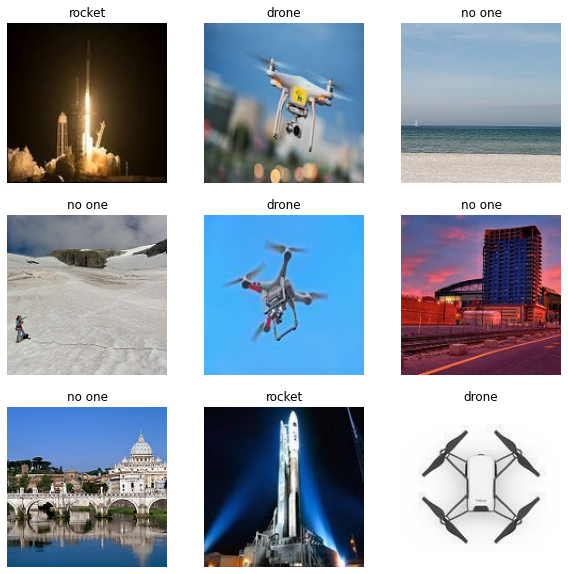

In [3]:
#Extract classes from dataset 
class_names = train_dataset.class_names

print('Classes: \n', class_names)

#Show top nine images from train dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
#Set prefetching to prevent memory bottleneck and improve training processing time
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
#Create data augmentation model. Due to the fact that our dataset is not large, data augmentation will help and prevent 
#some overfitting in CNN training process. For this project, it was chosen random horizontal flip, rotation and zoom
#In every step of training, the input image will be subject to a random flip, rotation and zoom. This process artificially increases the train dataset.

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)
])

In [6]:
#In this project it will be used a pre-trained CNN architecture called ResNet50V2 based on Deep Residual Networks. In order to pre processing tha image data
# it will be used the following keras application to normalizing the pixels value of input images.
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [7]:
#Instead of create and training a CNN from the beggining, it will be used a pre-trained model ResNet50 V2. So, we will use transfer learning to adapt this
# pre-trained neural network to our context. To do so, we will drop the top layers, or classifier layers.
img_shape = (150, 150) + (3,)
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=img_shape)

In [8]:
# For now, we will freeze all base model. In this way, only the top layers are subjected to training process.
base_model.trainable = False

#Model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

In [9]:
#Build classification model
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) #implement data augmentation
x = preprocess_input(x) #pre processing input images (normalizing getting pixels values beetween -1  and 1)
x = base_model(x, training=False) # set training = False, thus batch normalization layers will be in inference mode, avoiding changes in the trained weights
x = tf.keras.layers.GlobalAveragePooling2D()(x) # use global avg pooling to summarize the info in each channel
x = tf.keras.layers.Dropout(0.2)(x) # including dropout to avoid overfitting
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) #prediction layer containing 4 neurouns to classify

class_model = tf.keras.Model(inputs, outputs) #create model

In [10]:
#Compile model
base_learning_rate = 0.00001
class_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
#Check that only the classifier layers will be trained, all before networks are frozen.
class_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [12]:
#Training model
initial_epochs = 200

history = class_model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/200
34/34 [==============================] - 9s 105ms/step - loss: 1.8195 - accuracy: 0.3567 - val_loss: 1.7185 - val_accuracy: 0.3290
Epoch 2/200
34/34 [==============================] - 2s 46ms/step - loss: 1.6762 - accuracy: 0.3752 - val_loss: 1.6684 - val_accuracy: 0.3419
Epoch 3/200
34/34 [==============================] - 2s 46ms/step - loss: 1.7410 - accuracy: 0.3715 - val_loss: 1.6201 - val_accuracy: 0.3548
Epoch 4/200
34/34 [==============================] - 2s 46ms/step - loss: 1.6199 - accuracy: 0.4067 - val_loss: 1.5738 - val_accuracy: 0.3677
Epoch 5/200
34/34 [==============================] - 2s 46ms/step - loss: 1.5499 - accuracy: 0.4325 - val_loss: 1.5296 - val_accuracy: 0.3806
Epoch 6/200
34/34 [==============================] - 2s 46ms/step - loss: 1.5453 - accuracy: 0.3752 - val_loss: 1.4881 - val_accuracy: 0.3935
Epoch 7/200
34/34 [==============================] - 2s 46ms/step - loss: 1.5019 - accuracy: 0.4473 - val_loss: 1.4474 - val_accuracy: 0.3935
Epoch

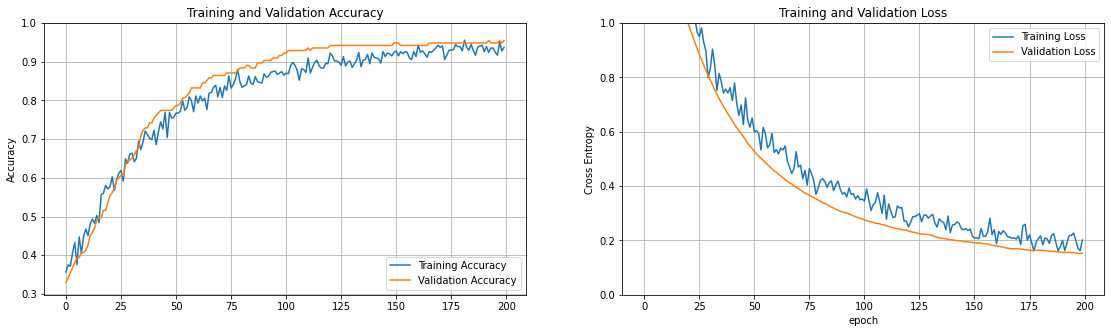

In [23]:
#Get training accuracy and loss history
acc = history.history['accuracy']
loss = history.history['loss']

#Get validation accuracy and loss history
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(19, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

The accuracy of model stabilzes around 0.92 or 92% of accuracy. It's possible to see that the behaviour of validation curves are close to the training, so there is no overfitting in model. 

In [24]:
#Evaluate accuracy test using test dataset
_, accuracy_eval = class_model.evaluate(test_dataset)
print('Test accuracy :', accuracy_eval)

5/5 [==============================] - 0s 45ms/step - loss: 0.2470 - accuracy: 0.8831
Test accuracy : 0.8831169009208679


The model presents 88,31% of accuracy when subjected to test dataset. It's a nice result for the project purposes.

Predictions:
 [2, 2, 1, 3, 1, 1, 1, 3, 0, 2, 1, 0, 2, 3, 1, 3]
Labels:
 [2 2 1 3 1 2 1 3 1 2 1 3 2 3 1 0]


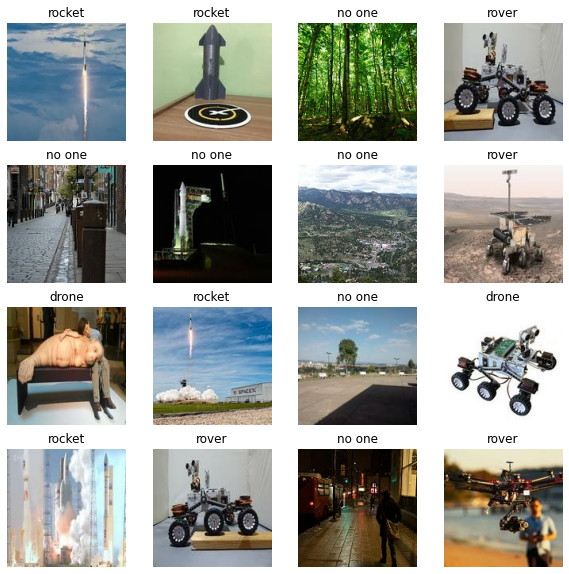

In [25]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = class_model.predict_on_batch(image_batch)

#Extract only the highest value from output layer
predictions = [np.argmax(predictions[i]) for i in range(0, 16)]

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

#Show the figures and predictions, on title, made by CNN
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

As we can see, the CNN correctly recognized most of the images. Despite figure 9 can be considered a huge mistake, the others presents similar features. This indicates that with more train, CNN could perform better.

In [26]:
#In order to improve the performance of CNN, it will be applied a fine tuning unfreezing some layers of base model. Thus, the tuned layers with pre-trained weights
# will learn features associated with our dataset.

#Unfreezing all base model
base_model.trainable = True

# Fine-tune beggining in layer 150 foward
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [27]:
#Compile model with a smaller learning rate
class_model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

#Check all trainable parameters 
class_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [28]:
#Amount of fine tuning epochs
fine_tune_epochs = 150

#Total epochs including initial epochs
total_epochs =  initial_epochs + fine_tune_epochs

#Fit model beggining at last epoch from history
history_fine = class_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 200/350
34/34 [==============================] - 8s 100ms/step - loss: 0.1811 - accuracy: 0.9279 - val_loss: 0.1461 - val_accuracy: 0.9484
Epoch 201/350
34/34 [==============================] - 2s 66ms/step - loss: 0.1888 - accuracy: 0.9279 - val_loss: 0.1398 - val_accuracy: 0.9484
Epoch 202/350
34/34 [==============================] - 2s 66ms/step - loss: 0.1549 - accuracy: 0.9482 - val_loss: 0.1362 - val_accuracy: 0.9484
Epoch 203/350
34/34 [==============================] - 2s 65ms/step - loss: 0.1431 - accuracy: 0.9445 - val_loss: 0.1357 - val_accuracy: 0.9548
Epoch 204/350
34/34 [==============================] - 2s 66ms/step - loss: 0.1660 - accuracy: 0.9556 - val_loss: 0.1300 - val_accuracy: 0.9548
Epoch 205/350
34/34 [==============================] - 2s 66ms/step - loss: 0.1403 - accuracy: 0.9556 - val_loss: 0.1309 - val_accuracy: 0.9548
Epoch 206/350
34/34 [==============================] - 2s 66ms/step - loss: 0.1746 - accuracy: 0.9261 - val_loss: 0.1293 - val_accuracy

In [29]:
#Evaluate accuracy test using test dataset
_, accuracy_eval = class_model.evaluate(test_dataset)
print('Test accuracy :', accuracy_eval)

5/5 [==============================] - 0s 47ms/step - loss: 0.0990 - accuracy: 0.9610
Test accuracy : 0.9610389471054077


The fine tuning considerably increased the accuracy on test dataset reaching 96,10% of accuracy.

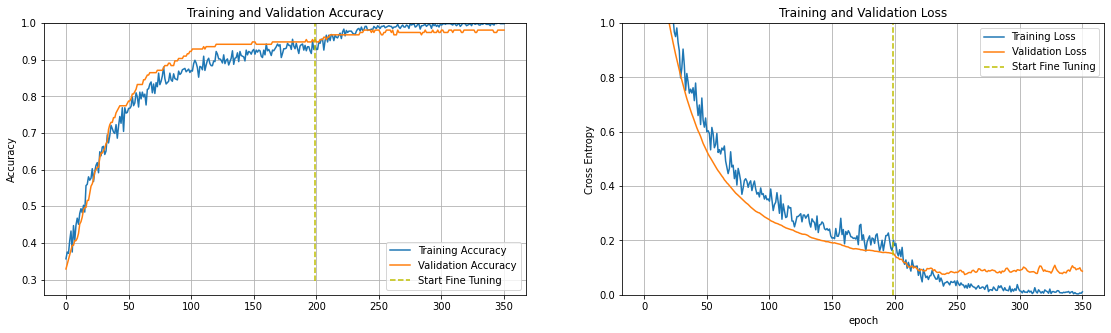

In [30]:
#Get training accuracy and loss history
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']

#Get validation accuracy and loss history
val_acc += history_fine.history['val_accuracy']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(19, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'y--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'y--', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

The plots above show that after start fine tuning (dashed yellow line) the performance learning was improved. However, the validation loss functions didn't change significantly, although training loss function decreased until close to zero.

Predictions:
 [2, 0, 1, 3, 1, 1, 3, 2, 3, 2, 0, 1, 3, 3, 3, 2]
Labels:
 [2 0 1 3 1 1 3 2 3 2 0 1 3 3 3 2]


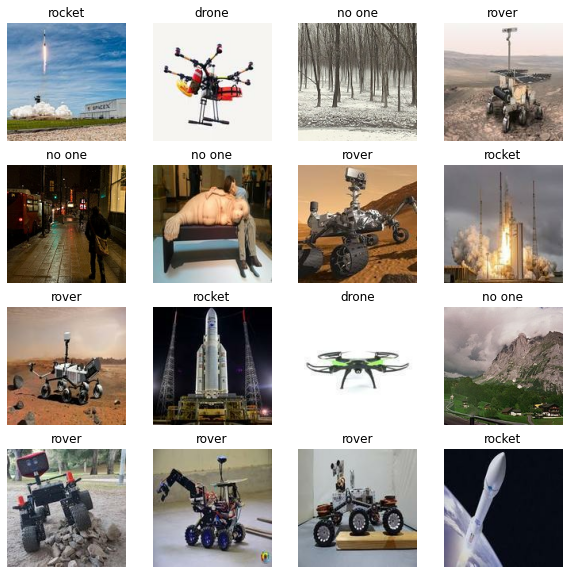

In [32]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = class_model.predict_on_batch(image_batch)

#Extract only the highest value from output layer
predictions = [np.argmax(predictions[i]) for i in range(0, 16)]

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

#Show the figures and predictions, on title, made by CNN
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


As we can see, in such batch of images, the CNN recognized correctly all classes.

In [35]:
#Save model
model_json = class_model.to_json()
with open('VehicleRecognition_ResNet50V2/model.json','w') as json_file:
    json_file.write(model_json)

#Save weights
class_model.save_weights('VehicleRecognition_ResNet50V2/model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
